# Dog Breed solution with fastai

### imports

In [1]:
from fastai.conv_learner import *
from fastai.transforms import *
from fastai.dataset import *
from fastai.conv_learner import *
from fastai.plots import *

### load the data

In [2]:
PATH =  'data/'
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
bs=16

# create a transformer
arch = resnext101_64
sz = 224
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on,
               max_zoom=1.1)

# the important part
data = ImageClassifierData.from_csv(PATH, 'train',
         label_csv, test_name='test',
         val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

Lets have a look at one of the images in the test set

In [3]:
fn = PATH + data.val_ds.fnames[0]; fn

'data/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [4]:
#img = PIL.Image.open(fn)
#img

In [5]:
def get_augs():
        x,_ = next(iter(data.aug_dl))
        return data.trn_ds.denorm(x)[1]

In [6]:
#ims = np.stack([get_augs() for i in range(6)])
#plots(ims, rows=2)

Here we can see how the images were transformed

### model

Now we will train a simple transferred model without any fancy tricks and see the results.

In [6]:
#learn = ConvLearner.pretrained(arch, data, precompute=True)
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [7]:
lr = 1e-2

In [9]:
#lrf=learn.lr_find()
#learn.sched.plot() --> optimal 1e-2

In [10]:
#learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.572188   0.289938   0.90362   
    1      0.364472   0.257365   0.917808                     



[array([0.25736]), 0.9178082191780822]

In [11]:
#learn.save("precomputed_2_cycles_plain_1e-2lr")

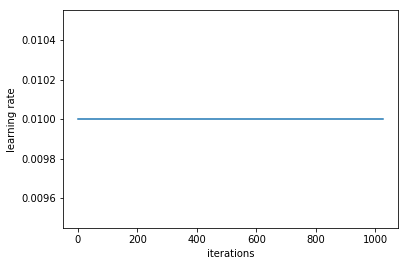

In [12]:
#learn.sched.plot_lr()

In [9]:
learn.precompute = False

In [8]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on,
                           max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', 
               f'{PATH}labels.csv', test_name='test', num_workers=4,
               val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [15]:
#learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.340077   0.232606   0.928571  
    1      0.327131   0.226566   0.924168                    
    2      0.264818   0.231432   0.921722                    
    3      0.292373   0.222747   0.920254                    
    4      0.274336   0.225398   0.921233                    



[array([0.2254]), 0.9212328767123288]

In [ ]:
#learn.save("5_cycles_SGDR_1e-2lr__2ndround")

In [11]:
#learn.load("5_cycles_SGDR_1e-2lr__2ndround")

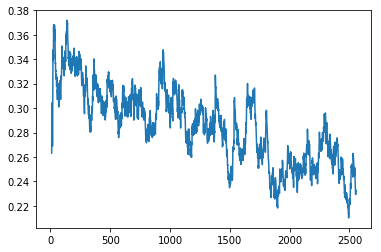

In [15]:
#learn.sched.plot_loss()

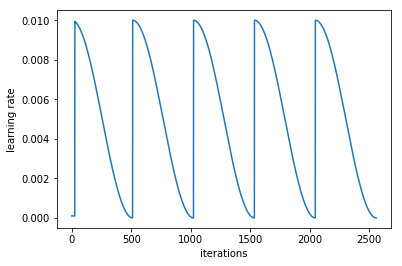

In [16]:
#learn.sched.plot_lr()

In [12]:
learn.unfreeze()
learn.bn_freeze(True) 

In [13]:
learn.set_data(get_data(299,bs))

 69%|██████▉   | 355/512 [06:44<02:59,  1.14s/it, loss=0.979] 

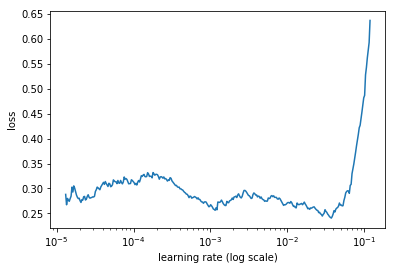

In [14]:
lrf=learn.lr_find()
learn.sched.plot()

In [15]:
lr = 1e-2

In [16]:
lrs = [lr/10, lr/3, lr]

In [17]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2) # --> overfit?

epoch      trn_loss   val_loss   accuracy                    
    0      0.196381   0.239538   0.921722  
    1      0.181882   0.261434   0.913894                    
    2      0.137514   0.244161   0.920254                    
    3      0.171621   0.257519   0.91683                     
    4      0.153106   0.244353   0.917319                    
    5      0.106646   0.24078    0.919276                     
    6      0.089286   0.23761    0.920744                     


[array([0.23761]), 0.9207436399217221]

In [9]:
learn.load("unfrozen_differential_3cycles_cyclemult2_SGDR_after_resize")

This one was a bit shaky and seems to degrade during the training, then find a good optimum and degrade again -> the new optimum was probably a steep one and therefore we popped out of it qickly, lets plot!

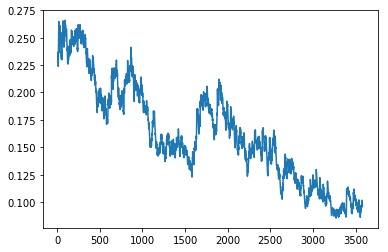

In [19]:
#learn.sched.plot_loss()

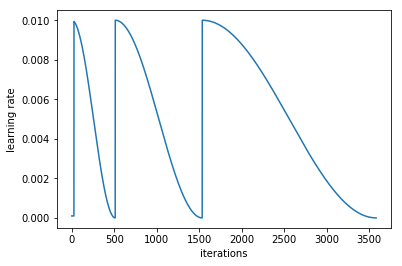

In [20]:
#learn.sched.plot_lr()

In [13]:
#log_preds,y = learn.TTA()
#probs = np.mean(np.exp(log_preds),0)

In [14]:
#accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9319960861056752, 0.21781583202213342)

In [15]:
#learn.save("after_TTA")

In [10]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [11]:
#accuracy_np(probs, y), metrics.log_loss(y, probs)

ValueError: y_true contains only one label (0.0). Please provide the true labels explicitly through the labels argument.

In [12]:
learn.save("TTA_on_test")

THATS IT!!!

In [13]:
ds = pd.DataFrame(probs)
ds.columns = data.classes

In [14]:
ds.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [15]:
ds.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,fd1a7be32f10493735555e62913c0841,4.698713e-07,2.795643e-07,1.777270e-09,1.488107e-09,2.429393e-10,1.691955e-11,8.489407e-09,8.372190e-11,2.321281e-09,...,7.057894e-07,2.178112e-09,1.472088e-08,2.512338e-10,2.256068e-10,8.313183e-10,2.076050e-10,3.464227e-11,4.082140e-10,1.705610e-10
1,5273d42f02b4715cb93845205995ef64,1.278190e-09,7.826267e-10,3.386238e-08,2.129270e-06,8.159258e-09,1.123106e-09,1.598993e-10,2.383890e-09,8.060234e-10,...,3.921594e-12,1.205083e-10,1.944194e-08,7.156064e-10,4.564384e-08,1.270672e-08,1.909689e-10,1.967125e-07,1.645431e-07,1.835048e-09
2,442057a3142f4d75a1023db363e2fb54,3.610746e-12,5.322364e-10,2.189695e-11,6.000279e-10,2.471356e-13,3.086278e-11,6.164334e-12,6.395255e-11,8.180846e-09,...,1.132664e-12,1.517233e-12,1.900583e-11,8.903515e-08,3.881322e-10,2.189911e-12,1.470683e-10,3.566339e-12,1.762437e-12,1.618449e-12
3,fb03302b030afd122e0f4936c158f6c1,9.962811e-06,3.295179e-10,1.361177e-10,7.405032e-12,4.190142e-11,1.718047e-10,1.810882e-09,7.308394e-11,6.329269e-10,...,2.805656e-07,3.574990e-11,7.063762e-10,6.450090e-12,8.446114e-11,3.730876e-11,5.308899e-10,4.476023e-10,9.413470e-11,3.342047e-06
4,511ca6e3539192aa5c8747bb697e0525,4.188200e-10,7.858826e-10,1.948582e-10,9.857920e-11,2.425461e-10,1.730287e-09,1.635494e-07,7.516890e-11,1.994690e-10,...,5.118948e-07,5.572934e-09,3.795763e-10,1.174259e-11,1.932940e-10,4.736376e-10,4.374166e-07,1.955000e-10,2.568096e-09,1.038698e-07


In [16]:
import os
SUBM = f'{PATH}sub/'
os.makedirs(SUBM, exist_ok=True) 
ds.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [17]:
FileLink(f'{SUBM}subm.gz')

/home/ubuntu/mine/DataProjects/DogBreed/data/sub/subm.gz

Lets try to take an inverse cycle mult this time

In [8]:
#learn.fit(1e-2, 3, cycle_len=4, cycle_mult=0.5) # --> 92.5 best performer!

epoch      trn_loss   val_loss   accuracy                    
    0      0.642036   0.315997   0.896771  
    1      0.420893   0.248227   0.914873                    
    2      0.326877   0.223855   0.927104                    
    3      0.352719   0.226198   0.922701                    
    4      0.298493   0.247209   0.914873                    
    5      0.257385   0.227255   0.924658                    
    6      0.289423   0.232595   0.929061                    



[array([0.2326]), 0.9290606653620352]

Here we got a pretty good accuracy, we went up and down some times, lets plot!

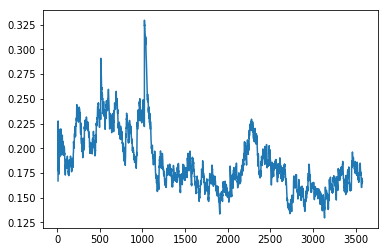

In [18]:
#learn.sched.plot_loss()

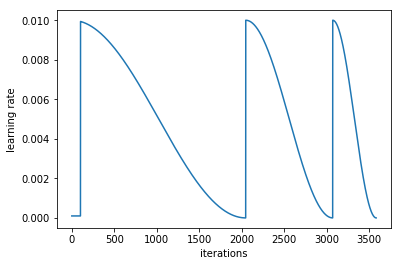

In [19]:
#learn.sched.plot_lr()

In [26]:
#model_something = learn.get_layer_groups()
#model_something

In [31]:
#model_model = learn.model
#type(model_model)

torch.nn.modules.container.Sequential

In [12]:
#learn.fit(1e-2, 3) --> 91.5 accuracy

epoch      trn_loss   val_loss   accuracy                    
    0      0.613243   0.30998    0.90998   
    1      0.479756   0.276785   0.908023                    
    2      0.381476   0.265625   0.914873                    


[array([0.26563]), 0.9148727985510854]

In [ ]:
#learn.fit(0.0316227766, 3) --> 88.5 accuracy

epoch      trn_loss   val_loss   accuracy                    
    0      0.651989   0.427105   0.885519  


In [9]:
#learn.load('simple learner 3 epochs')

In [10]:
#data.val_y

array([ 19,  15,   7, ..., 109,   3,  28])

In [11]:
#log_preds = learn.predict()

In [12]:
#log_preds.shape

(2044, 120)

In [13]:
#log_preds[:1]

array([[-17.44805, -18.13577, -19.49283, -22.07457, -16.49046, -19.35214, -18.87661, -14.52942, -17.0623 ,
        -18.60798, -18.38213, -18.39494, -17.65259, -16.84655, -19.91055, -18.34753, -17.38764, -20.24043,
        -17.31937,  -0.00005, -19.46349, -15.5388 , -16.82854, -19.11229, -20.33829, -15.75918, -18.00252,
        -13.77136, -19.54037, -13.86643, -16.66206, -17.48421, -18.42878, -18.0753 , -20.48493, -18.37935,
        -20.62319, -17.27576, -17.10617, -20.15236, -18.79759, -15.43214, -19.78439, -18.65773, -20.62911,
        -10.20809, -18.21198, -20.01008, -18.42609, -19.07699, -18.48695, -17.79191, -18.70012, -15.78736,
        -18.67442, -16.13681, -18.8381 , -18.47062, -17.81063, -18.45806, -13.76911, -13.4989 , -18.96618,
        -17.28768, -21.34929, -18.39214, -22.18714, -19.17106, -18.09194, -18.31328, -18.30644, -15.96063,
        -18.11958, -18.18331, -16.07643, -15.9771 , -18.94203, -15.49737, -18.46433, -19.84239, -20.06217,
        -18.48482, -17.65934, -19.969

In [14]:
#preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
#preds

array([ 19,  15,   7, ..., 109,   3,  28])

In [15]:
#probs = np.exp(log_preds[1,:])        # pr(dog)
#probs[:]

array([0.     , 0.     , 0.00002, 0.     , 0.     , 0.00001, 0.     , 0.     , 0.00011, 0.00002, 0.00001,
       0.     , 0.00001, 0.     , 0.00001, 0.99068, 0.     , 0.00001, 0.     , 0.00001, 0.00001, 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.00001, 0.     , 0.     , 0.00002, 0.     , 0.00014, 0.00032, 0.00003, 0.00004, 0.     ,
       0.     , 0.     , 0.00001, 0.00165, 0.00002, 0.     , 0.     , 0.00003, 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.00041, 0.00009, 0.00001,
       0.     , 0.00001, 0.     , 0.     , 0.     , 0.00001, 0.00001, 0.     , 0.     , 0.     , 0.00001,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.00001, 0.     , 0.     , 0.     , 0.00004, 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.00001, 0. 

Lets see where we were wrong and where we were right

[1498  126 1867 1367]


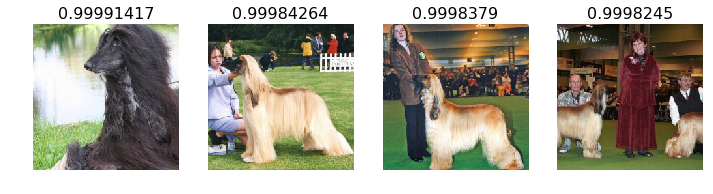

In [16]:
#imr = ImageModelResults(data.val_ds, log_preds)
#imr.plot_most_correct(1)

[1667]


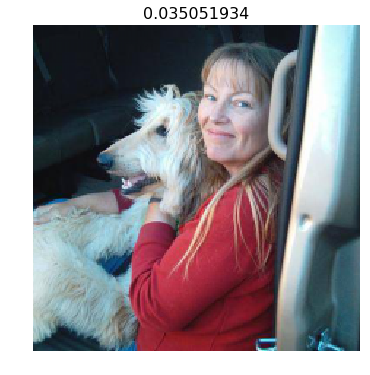

In [17]:
#imr.plot_most_incorrect(1)

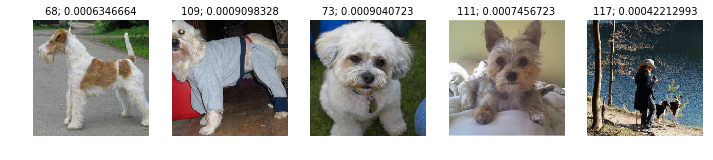

In [22]:
#imr.plot_by_most_correct_target_class(Y=data.val_y, is_correct=False,  n=5, fontsize=10)